<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%B4%D1%80%D0%BE%D0%BF%D0%B0%D1%83%D1%82_%D0%B4%D0%BE%D0%B1%D0%B0%D0%B2%D0%BB%D1%8F%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 5.0MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533280 sha256=bebd0c50e5f1cb3c669592aa36b7f9ab9b7bee1caa6e290602ef0a27707b7da4
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=07a1fac848987bbe10a899516fed5bd641e74c0f82c3c15f7caa9b8147a10fcf
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-aam4cb93
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-aam4cb93
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=c92cf960b516f53f8d7e58e8ee790500d132d5c09d4af9984cd947b7ed0bcf5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8j41f8qq/wheels/9c/7a/cc/d1ffa9ccaa42b

In [ ]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_dropout_27.10.2020.pkl'

# Загрузка истории

In [ ]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.840267,6.937616
2010-01-05,6.616219,5.005957,10.896401,7.396526
2010-01-06,6.510980,4.798555,10.840267,7.673220
2010-01-07,6.498945,4.939965,11.401575,7.868933
2010-01-08,6.542150,4.845690,11.647147,7.889179
...,...,...,...,...
2020-10-21,116.870003,12.750000,7.320000,7.850000
2020-10-22,115.750000,13.150000,7.720000,8.210000
2020-10-23,115.040001,12.600000,7.630000,8.160000


# Алгоритм распределения

In [ ]:
def predWeights(dData,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = dData.shape[1]
    
    X = pd.concat([dData.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    y = dData
    xy = pd.concat([y[-learnLen:],X[-learnLen:]],axis=1).dropna()
    y = xy.iloc[:,:n]
    X = xy.iloc[:,n:]
    
    def loss_function(y_true, y_pred):
        return -tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n+1,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=loss_function)
    #help(model.fit)
    learn_res = model.fit(X, y, epochs=1000,validation_split=0.2,verbose=False,use_multiprocessing=True,callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([dData.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1,:-1]

    return weights

dData = data.to_returns()
#t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.24370658 0.18664376 0.2984763  0.19253524] 0.07863810658454895
[0.05746797 0.60185516 0.15213007 0.05694662] 0.13160018250346184
[0.16768265 0.11724398 0.17815554 0.39695808] 0.13995975255966187
[0.277515   0.12737857 0.15083131 0.35408422] 0.09019090235233307
[0.06031465 0.23140977 0.35323283 0.28210184] 0.07294090837240219
[0.17026328 0.1298461  0.21512079 0.35510457] 0.12966527044773102
[0.12682158 0.20526251 0.20130941 0.3377481 ] 0.12885838747024536
[0.16889283 0.2573793  0.20495546 0.22791904] 0.1408533751964569
[0.05278935 0.11783859 0.066365   0.52785623] 0.23515082523226738
[0.08164559 0.3534517  0.32866347 0.12088434] 0.11535489559173584


In [ ]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        dData = target.universe[selected].to_returns()
        
        weights = predWeights(dData,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({dData.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [ ]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    # print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    # print(weights)

    d = dData[t:(t+lag)]                # данные
    
    p = sum(d.mean().values*weights)    # на прогнозе среднее
    m = d.values.mean()                 # на курсах среднее
    v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    return (p-m)/v

## Создание модели

In [ ]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,200),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(1,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  3421 {'quality': 0.07772071374289688, 'lookback': 58, 'learnLen': 133, 'reg': -2.5300000000000953, 'min_delta': -6.98, 'lr': -1.1300000000001251, 'hl': 314, 'lag': 163, 'doRate': 0.03}
finish -  3431 {'quality': 0.04135907088183835, 'lookback': 62, 'learnLen': 126, 'reg': -2.880000000000088, 'min_delta': -6.870000000000003, 'lr': -1.0500000000001268, 'hl': 570, 'lag': 158, 'doRate': 0.09999999999999999}
finish -  3441 {'quality': 0.13472292823022192, 'lookback': 90, 'learnLen': 135, 'reg': -3.010000000000085, 'min_delta': -6.470000000000011, 'lr': -2.500000000000096, 'hl': 258, 'lag': 155, 'doRate': 0.06999999999999999}
finish -  3451 {'quality': -0.005139035897018893, 'lookback': 61, 'learnLen': 79, 'reg': -6.53000000000001, 'min_delta': -6.230000000000016, 'lr': -2.360000000000099, 'hl': 266, 'lag': 163, 'doRate': 0.06999999999999999}
finish -  3461 {'quality': -0.015872445377467206, 'lookback': 66, 'learnLen': 172, 'reg': -6.6500000000000075, 'min_delta': -6.65000000000000

KeyboardInterrupt: ignored

## Графики

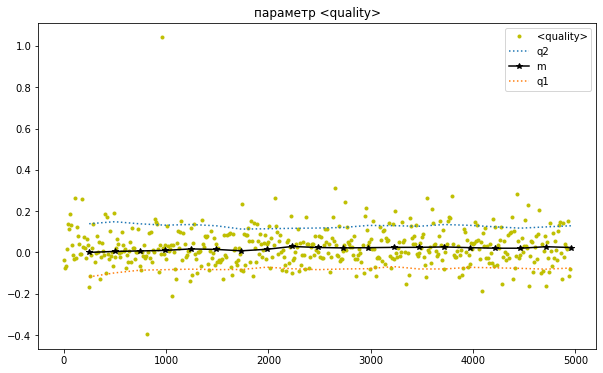

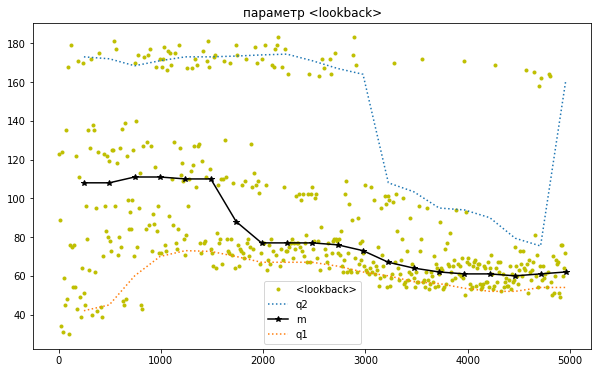

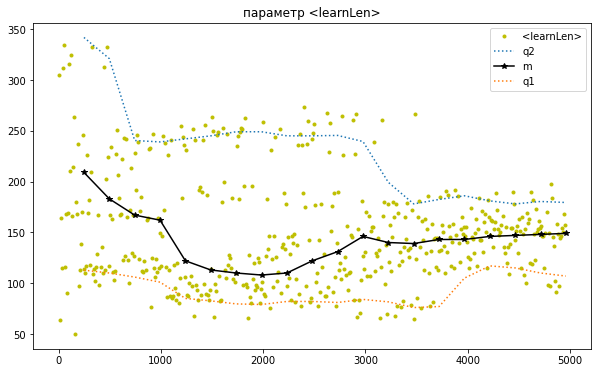

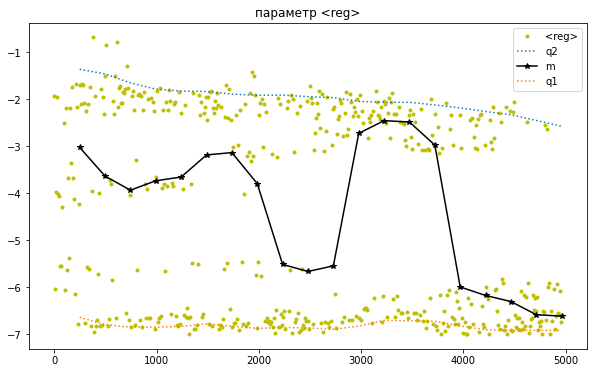

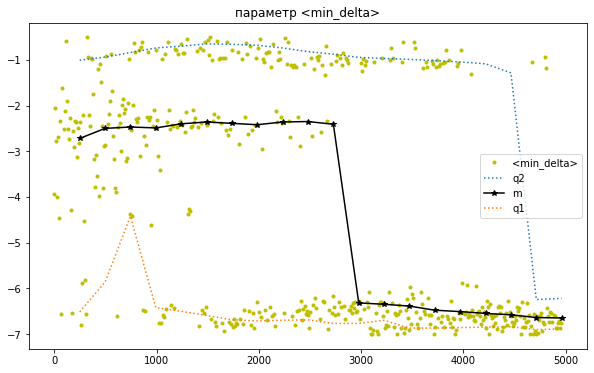

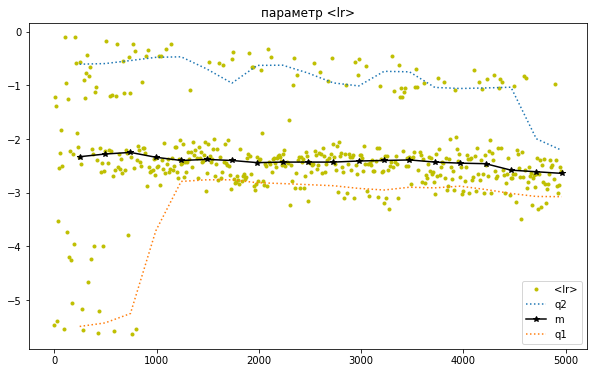

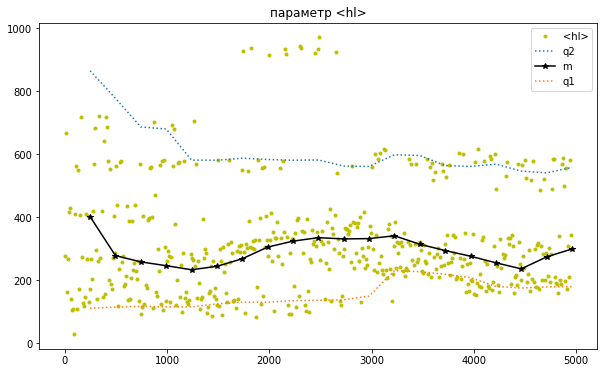

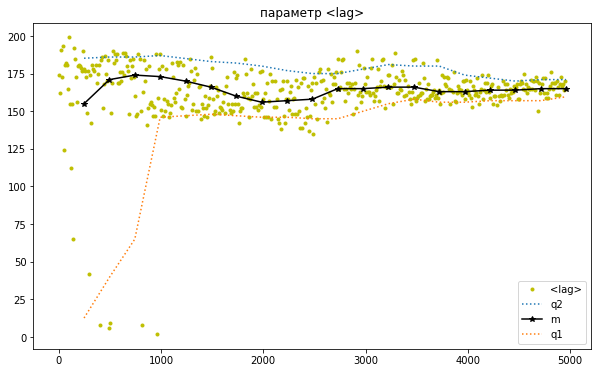

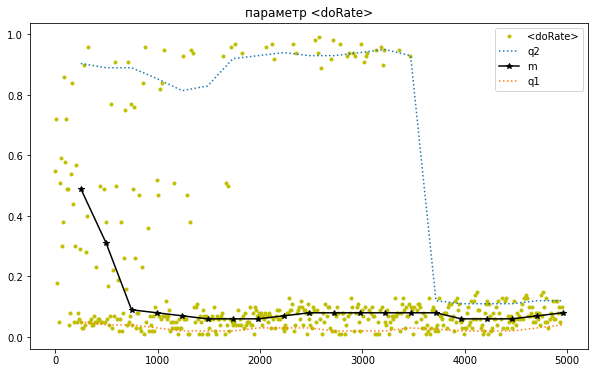

In [ ]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.09,
 'hl': 327,
 'lag': 165,
 'learnLen': 144,
 'lookback': 79,
 'lr': -2.630000000000093,
 'min_delta': -6.07000000000002,
 'reg': -5.9900000000000215}

# Прогон лучшей

In [ ]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:00равновесный
0% [############################# ] 100% | ETA: 00:00:00

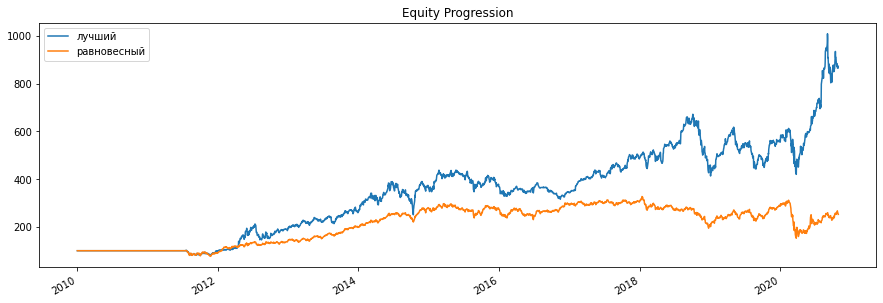

In [ ]:
res_best.plot()

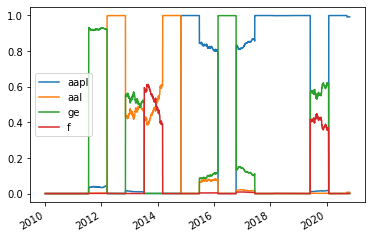

In [ ]:
res_best.get_security_weights().plot()

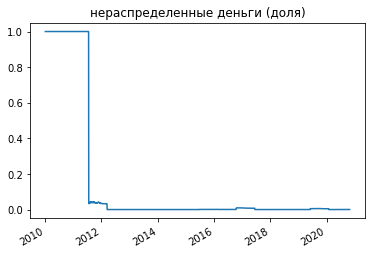

In [ ]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

In [ ]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-10-27  2020-10-27
Risk-free rate       0.00%       0.00%

Total Return         772.73%     152.19%
Daily Sharpe         0.83        0.48
Daily Sortino        1.37        0.75
CAGR                 22.18%      8.93%
Max Drawdown         -38.51%     -53.46%
Calmar Ratio         0.58        0.17

MTD                  0.27%       7.00%
3m                   22.65%      14.28%
6m                   64.69%      42.35%
YTD                  56.41%      -12.55%
1Y                   82.41%      -2.80%
3Y (ann.)            23.34%      -5.51%
5Y (ann.)            17.30%      -2.32%
10Y (ann.)           24.19%      9.69%
Since Incep. (ann.)  22.18%      8.93%

Daily Sharpe         0.83        0.48
Daily Sortino        1.37        0.75
Daily Mean (ann.)    24.41%      11.44%
Daily Vol (ann.)     29.57%      24.01%
Daily Skew           0.28    

Енин А.В.

Оренбург